# Setup

In [38]:
# Parameters

## Years
start_year = 2021
end_year = 2022
base_year = start_year
years = range(start_year, end_year + 1)

## Grouping
young_age_cutoff=25
old_age_threshold=65

## Indexing
price_variable = 'mehir' # 'mehir' or 'omdan'

## Output
top_n = 5
comparison_year = end_year
comparison_level = 'primary'

## Folder Names
cex_data_folder="/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/"
folder_names_pathname='Data_clean/CEX_folder_names.csv'
age_groups_pathname='Data_clean/age_groups.csv'
prodcode_dict_pathname = 'Data_clean/prodcode_dictionary_c3-c399.csv'
    
## Libraries
import pandas as pd
import pyreadstat  
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Data

In [39]:
# Load folder names
folder_names_df = pd.read_csv(folder_names_pathname)

# Load age groups
age_groups_df = pd.read_csv(age_groups_pathname)
young_age_group_id = age_groups_df[(age_groups_df['min_age'] <= young_age_cutoff) & (age_groups_df['max_age'] >= young_age_cutoff)].index[0] + 1
old_age_group_id = age_groups_df[(age_groups_df['min_age'] <= old_age_threshold) & (age_groups_df['max_age'] >= old_age_threshold)].index[0] + 1

# Load household data for each year
dfs_mb = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_HH_pathname = f"{cex_data_folder}{subfolder}/{subfolder}datamb.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_HH_pathname)
    df.columns = df.columns.str.lower()
    if 'gil' in df.columns:
        df.rename(columns={'gil': 'age_group'}, inplace=True)
    df['misparmb'] = df['misparmb'].astype(int)
    dfs_mb[year] = df

# Load individual data for each year
dfs_prat = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_IND_pathname = f"{cex_data_folder}{subfolder}/{subfolder}dataprat.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_IND_pathname)
    df.columns = df.columns.str.lower()
    if 'gil' in df.columns:
        df.rename(columns={'gil': 'age_group'}, inplace=True)
    df['misparmb'] = df['misparmb'].astype(int)
    dfs_prat[year] = df

# Load expenses data for each year
dfs_prod = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_prices_pathname = f"{cex_data_folder}{subfolder}/{subfolder}dataprod.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_prices_pathname)
    df.columns = df.columns.str.lower()
    df['misparmb'] = df['misparmb'].astype(int)
    df['prodcode'] = df['prodcode'].astype(int).astype(str)
    dfs_prod[year] = df

# Load survey data for each year
dfs_survey = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_prices_pathname = f"{cex_data_folder}{subfolder}/{subfolder}datayoman.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_prices_pathname)
    df.columns = df.columns.str.lower()
    df['misparmb'] = df['misparmb'].astype(int)
    df['prodcode'] = df['prodcode'].astype(int).astype(str)
    dfs_survey[year] = df

# Grouping

## Data

In [40]:
Groups = {}
for year in years:
    Groups[year] = pd.DataFrame(dfs_mb[year]['misparmb'].unique(), columns=['misparmb'])

In [41]:
for year in years:
    dfs_mb_year = dfs_mb[year]
    dfs_prat_year = dfs_prat[year]

    nationality_map = {1: 'Jewish', 2: 'Arab'}
    observance_map = {1: 'Secular', 2: 'Conservative', 3: 'Religious', 4: 'Ultra-Orthodox', 5: 'Mixed'}

    Groups[year]['Nationality'] = dfs_mb_year['nationality'].map(nationality_map).fillna('Other')
    Groups[year]['Observance'] = dfs_mb_year['ramatdatiyut'].map(observance_map).fillna('Other')

    age_group_map = {age_group_id: 'Young' if age_group_id <= young_age_group_id else 'Old' if age_group_id >= old_age_group_id else 'Middle' for age_group_id in dfs_prat_year['age_group'].unique()}
    Groups[year]['Age_Group'] = dfs_prat_year.loc[dfs_prat_year['y_kalkali'] == 1, 'age_group'].map(age_group_map).values

    Groups[year]['Income_Decile'] = dfs_mb_year['decile'].fillna(0).astype(int)

    Groups[year]['Income_Quintile'] = pd.cut(dfs_mb_year['decile'], bins=[0, 2, 4, 6, 8, 10], labels=[1, 2, 3, 4, 5])

    Groups[year]['SES_Quintile'] = dfs_mb_year['cluster'].apply(lambda x: x if x in range(1, 6) else np.nan).fillna(0).astype(int)
    Groups[year]['SES_Tertile'] = dfs_mb_year['cluster'].apply(lambda x: 1 if x in [1, 2] else 2 if x == 3 else 3 if x in [4, 5] else np.nan).fillna(0).astype(int)

    Groups[year]['Children'] = dfs_mb_year['nefashotad18'].fillna(0).astype(int)
    Groups[year]['Family_Size'] = Groups[year]['Children'].apply(lambda x: 'no children' if x == 0 else '1 to 3' if x in [1, 2, 3] else '4 plus')


In [42]:
'''
groups_mmb = {}
for year in years:
    for group in Groups[year].columns[1:]:
        for subgroup in Groups[year][group].unique():
            groups_mmb[(year, group, subgroup)] = Groups[year][Groups[year][group] == subgroup]['misparmb'].values
'''

"\ngroups_mmb = {}\nfor year in years:\n    for group in Groups[year].columns[1:]:\n        for subgroup in Groups[year][group].unique():\n            groups_mmb[(year, group, subgroup)] = Groups[year][Groups[year][group] == subgroup]['misparmb'].values\n"

## Groups Dataframes Headers

In [43]:
for year in years:
    display(HTML(f"<h2>Groups for Year {year}</h2>"))
    display(HTML(Groups[year].head().to_html(index=False)))
    print(f"Number of observations: {len(dfs_mb[year])}")


misparmb,Nationality,Observance,Age_Group,Income_Decile,Income_Quintile,SES_Quintile,SES_Tertile,Children,Family_Size
28106,Jewish,Secular,Old,10,5,4,3,0,no children
28107,Jewish,Secular,Old,10,5,4,3,0,no children
28108,Jewish,Ultra-Orthodox,Middle,2,1,3,2,7,4 plus
28109,Jewish,Religious,Old,1,1,3,2,0,no children
28110,Jewish,Conservative,Old,4,2,3,2,0,no children


Number of observations: 6057


misparmb,Nationality,Observance,Age_Group,Income_Decile,Income_Quintile,SES_Quintile,SES_Tertile,Children,Family_Size
57089,Jewish,Conservative,Old,3,2,3,2,0,no children
57090,Jewish,Secular,Old,7,4,3,2,0,no children
57091,Jewish,Secular,Middle,2,1,3,2,3,1 to 3
57092,Jewish,Secular,Middle,4,2,3,2,1,1 to 3
57093,Arab,Secular,Middle,10,5,3,2,0,no children


Number of observations: 5478


## Plot Groups Distribution

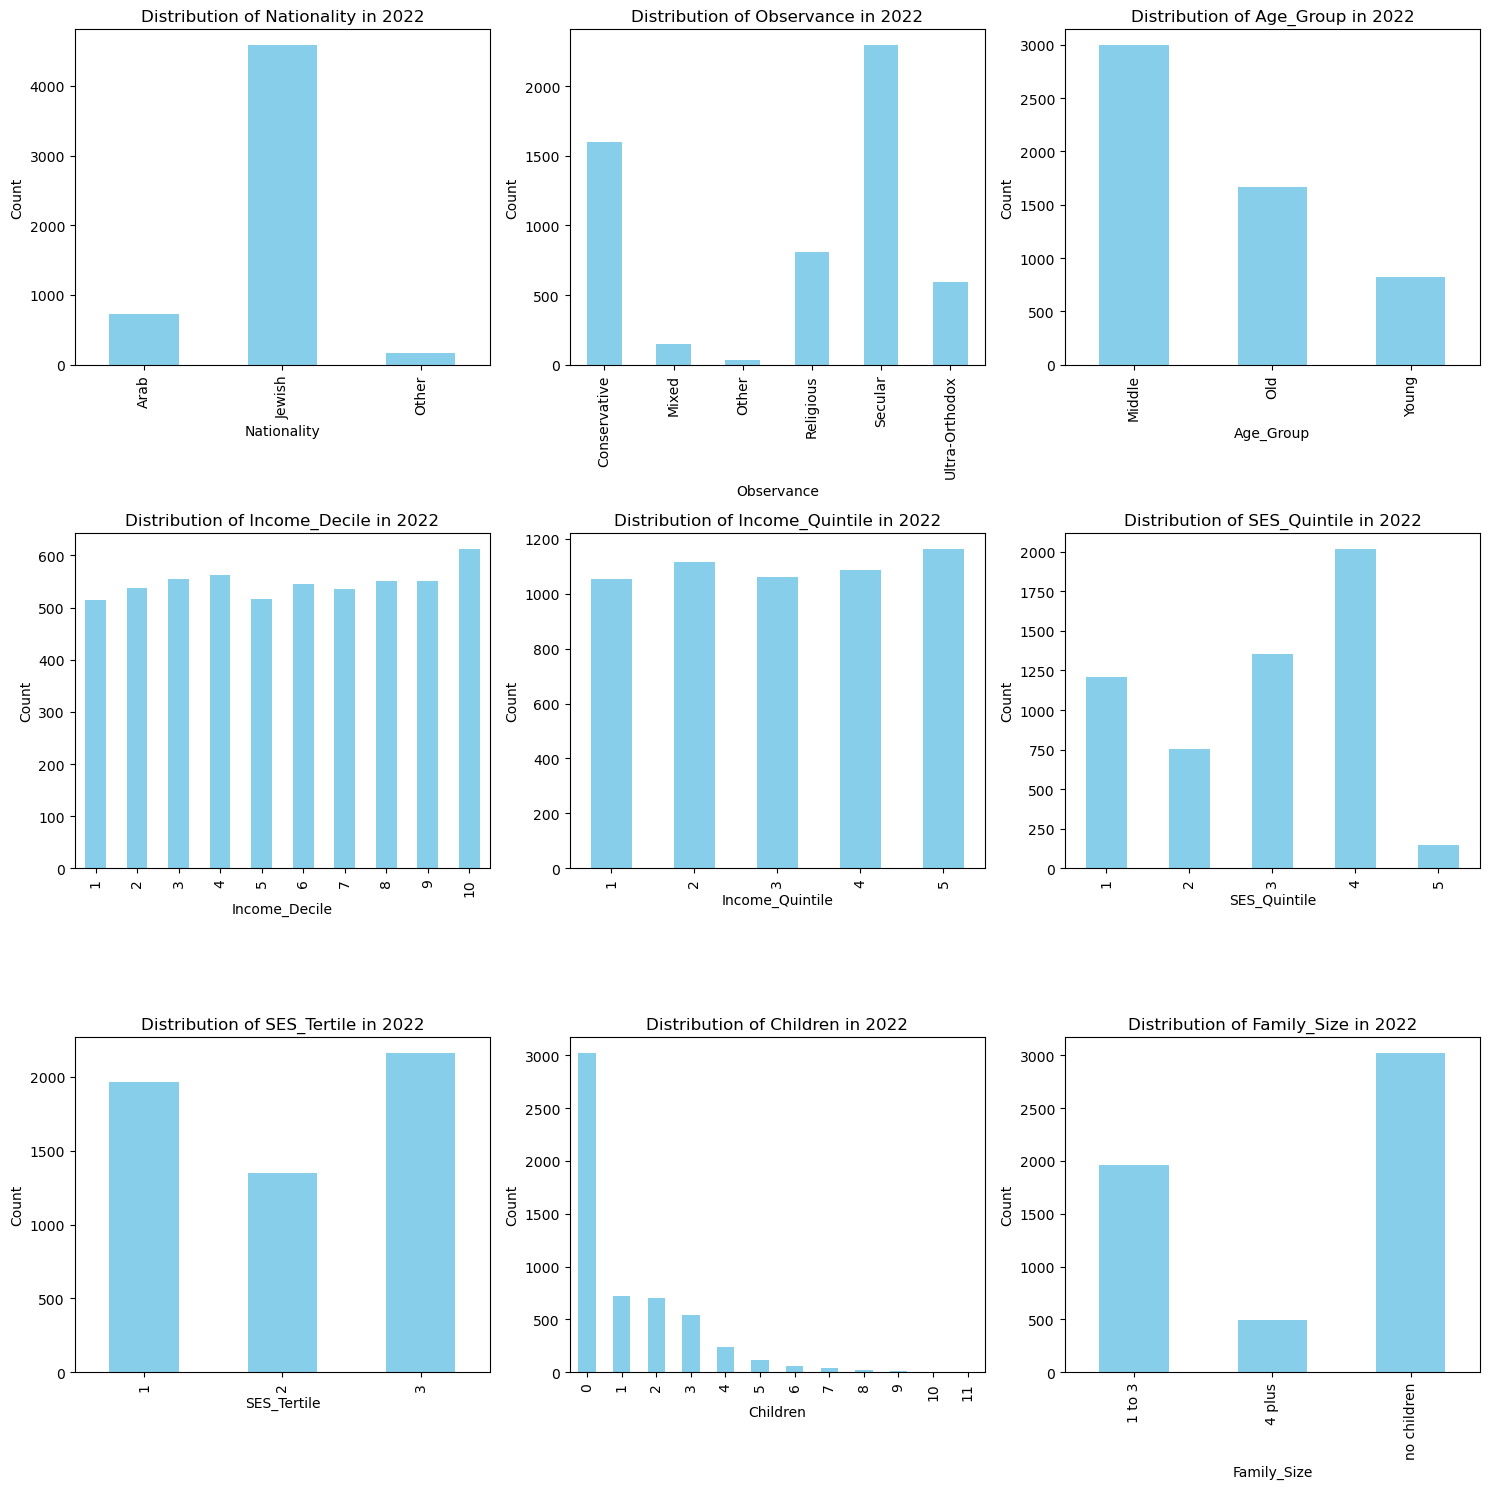

In [44]:
# Get the columns to plot
columns_to_plot = [col for col in Groups[end_year].columns if col != 'misparmb']

# Calculate the number of rows needed
ncols = 3
nrows = (len(columns_to_plot) + ncols - 1) // ncols

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for ax, column in zip(axes, columns_to_plot):
    Groups[end_year][column].value_counts().sort_index().plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {column} in {end_year}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Remove any unused subplots
for ax in axes[len(columns_to_plot):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# Indexing

## Laspeyres Index

$$
I_{i}=\frac{\sum_{j\in L}{\frac{P_{ij}}{P_{oj}}(P_{oj}Q_{oj})}}{\sum_{j\in L}P_{oj}Q_{oj}}\times 100
$$

$$\text{For our purposes:}$$

$$
I_{ij}=\frac{P_{ij}}{P_{oj}}
$$
$$
W_{oj}=\frac{P_{oj}Q_{oj}}{\sum_{j\in L}P_{oj}Q_{oj}}
$$
$$
I_{i}=\sum_{j\in L}W_{oj}I_{ij}\times 100
$$



$$
\text{Where:}\\
I_{i}\text{  - Index for the current period}\\
Q_{oj}\text{  - Quantity of the good or service in the base period}\\
P_{oj}\text{  - Price of the good or service in the base period}\\
P_{ij}\text{  - Price of the good or service in the current period}\\
L\text{  - The set of all goods and services in the index basket}\\
$$

In [45]:
# Drop the 'Children' column
for year in years:
    Groups[year] = Groups[year].drop(columns=['Children'])

## Calculate Weights

In [46]:
def calculate_weights(product_level, year, group_mmb = None):
    # Expenses dataframe for consumption expenses only
    expenses_df = dfs_prod[year][dfs_prod[year]['prodcode'].astype(str).str.startswith('3')]

    if group_mmb is not None:
        # Filter only IDs that match the group
        expenses_df = expenses_df[expenses_df['misparmb'].isin(group_mmb)].reset_index(drop=True)

    # Keep only the product codes at the correct product level
    expenses_df = expenses_df[expenses_df['prodcode'].str.len() == product_level]

    # Sum the expense for each prodcode
    expenses_df = expenses_df.groupby('prodcode')['schum'].sum().reset_index()

    # Calculate weights
    expenses_df['weight'] = expenses_df['schum'] / expenses_df['schum'].sum()

    return expenses_df

In [47]:
product_level = 6
year = base_year

weights = {}
for group in Groups[year].columns[1:]:
    weights[group] = {}  
    for subgroup in Groups[year][group].unique():
        mmb = Groups[year][Groups[year][group] == subgroup]['misparmb']
        weights[group][subgroup] = calculate_weights(product_level, year, mmb)
weights['All'] = calculate_weights(product_level, year, None)

## Prices

In [48]:
def calculate_prices(year, group_mmb = None):
    # Prices dataframe for consumption expenses only
    prices_df = dfs_survey[year][dfs_survey[year]['prodcode'].astype(str).str.startswith('3')].copy()

    if group_mmb is not None:
        # Filter only IDs that match the group
        prices_df = prices_df[prices_df['misparmb'].isin(group_mmb)].reset_index(drop=True)

    # Calculate prices
    prices_df['price'] = prices_df['mehir'].fillna(0) / prices_df['kamut'].fillna(1)

    # Group by product code and calculate the mean price
    prices_df = prices_df.groupby('prodcode', as_index=False)['price'].mean()

    return prices_df

In [49]:
prices = {}
for year in years:
    prices[year] = {}
    for group in Groups[year].columns[1:]:
        prices[year][group] = {}
        for subgroup in Groups[year][group].unique():
            mmb = Groups[year][Groups[year][group] == subgroup]['misparmb']
            prices[year][group][subgroup] = calculate_prices(year, mmb)
    prices[year]['All'] = calculate_prices(year, None)

## Indexes

In [50]:
def calculate_indexes(weights, prices, prices_base):
    prices_base = prices_base.rename(columns={'price': 'price_base'})
    weights = weights.drop(columns=['schum'])
    # Merge weights and prices dataframes
    merged_df = weights.merge(prices, on='prodcode', how='left')
    merged_df = merged_df.merge(prices_base[['prodcode', 'price_base']], on='prodcode', how='left')

    # Replace inf or 0 prices with nan
    merged_df['price'] = merged_df['price'].replace([np.inf, 0], np.nan)

    # Calculate price divided by the base year price
    merged_df['price_ratio'] = merged_df['price'] / merged_df['price_base']

    # If one of the prices is missing, assume no change
    merged_df['price_ratio'] = merged_df['price_ratio'].fillna(1)

    return merged_df

In [51]:
price_indexes = {}
for year in years:
    price_indexes[year] = {}
    for group in Groups[year].columns[1:]:
        price_indexes[year][group] = {}
        for subgroup in Groups[year][group].unique():
            price_indexes[year][group][subgroup] = calculate_indexes(weights[group][subgroup], prices[year][group][subgroup], prices[base_year][group][subgroup])
    price_indexes[year]['All'] = calculate_indexes(weights['All'], prices[year]['All'], prices[base_year]['All'])

## Laspeyres Group Indexes

In [56]:
yearly_indexes = {}
for group in Groups[base_year].columns[1:]:
    # Initialize dataframe
    df = pd.DataFrame({'year': years})
    for subgroup in Groups[base_year][group].unique():
        df[subgroup] = None 
    for year in years:
        for subgroup in Groups[year][group].unique():
            df.loc[df['year'] == year, subgroup] = (price_indexes[year][group][subgroup]['price_ratio'] * price_indexes[year][group][subgroup]['weight']).sum() * 100
    yearly_indexes[group] = df

# Add 'All' group
df_all = pd.DataFrame({'year': years})
df_all['All'] = None
for year in years:
    df_all.loc[df_all['year'] == year, 'All'] = (price_indexes[year]['All']['price_ratio'] * price_indexes[year]['All']['weight']).sum() * 100
yearly_indexes['All'] = df_all

# Plots

## Price Index Over Time

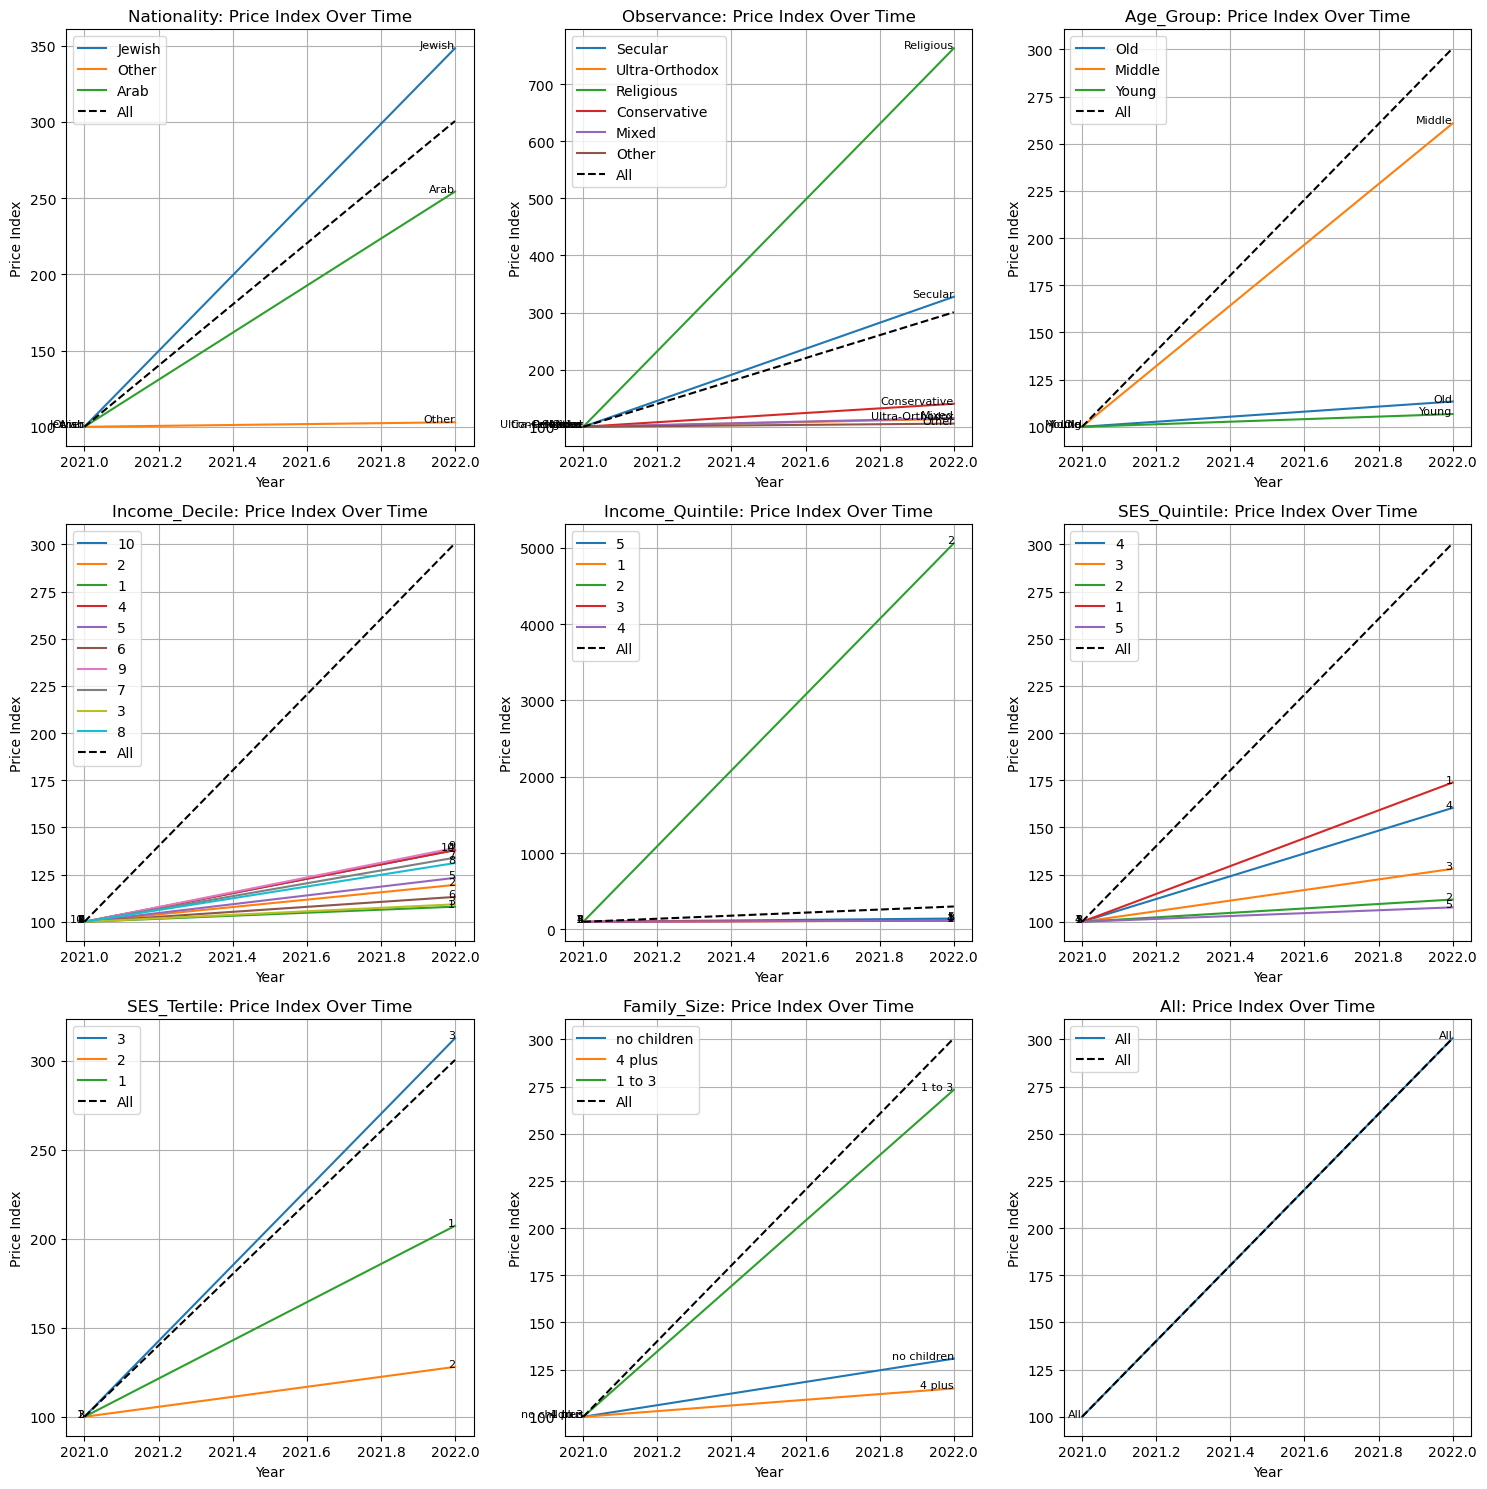

In [58]:
def price_index_over_time(yearly_indexes):
    import matplotlib.pyplot as plt

    # Calculate the number of groups
    n_groups = len(yearly_indexes) - 1
    ncols = 3
    nrows = (n_groups + ncols - 1) // ncols

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.flatten()

    # Plot each group
    for ax, (group, yearly_indexes_group) in zip(axes, yearly_indexes.items()):
        years = yearly_indexes_group['year']
        indexes = yearly_indexes_group.drop(columns=['year'])
        for subgroup in indexes.columns:
            ax.plot(years, indexes[subgroup], label=subgroup)
            for i, year in enumerate(years):
                ax.text(year, indexes[subgroup].iloc[i], subgroup, fontsize=8, ha='right')
        # Add dotted line for 'All'
        if 'All' in yearly_indexes:
            all_years = yearly_indexes['All']['year']
            all_indexes = yearly_indexes['All']['All']
            ax.plot(all_years, all_indexes, label='All', linestyle='--', color='black')
        ax.set_title(f"{group}: Price Index Over Time")
        ax.set_xlabel('Year')
        ax.set_ylabel('Price Index')
        ax.legend()
        ax.grid(True)

    # Remove any unused subplots
    for ax in axes[len(yearly_indexes):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

# Example usage
price_index_over_time(yearly_indexes)


## Top Weight Differences

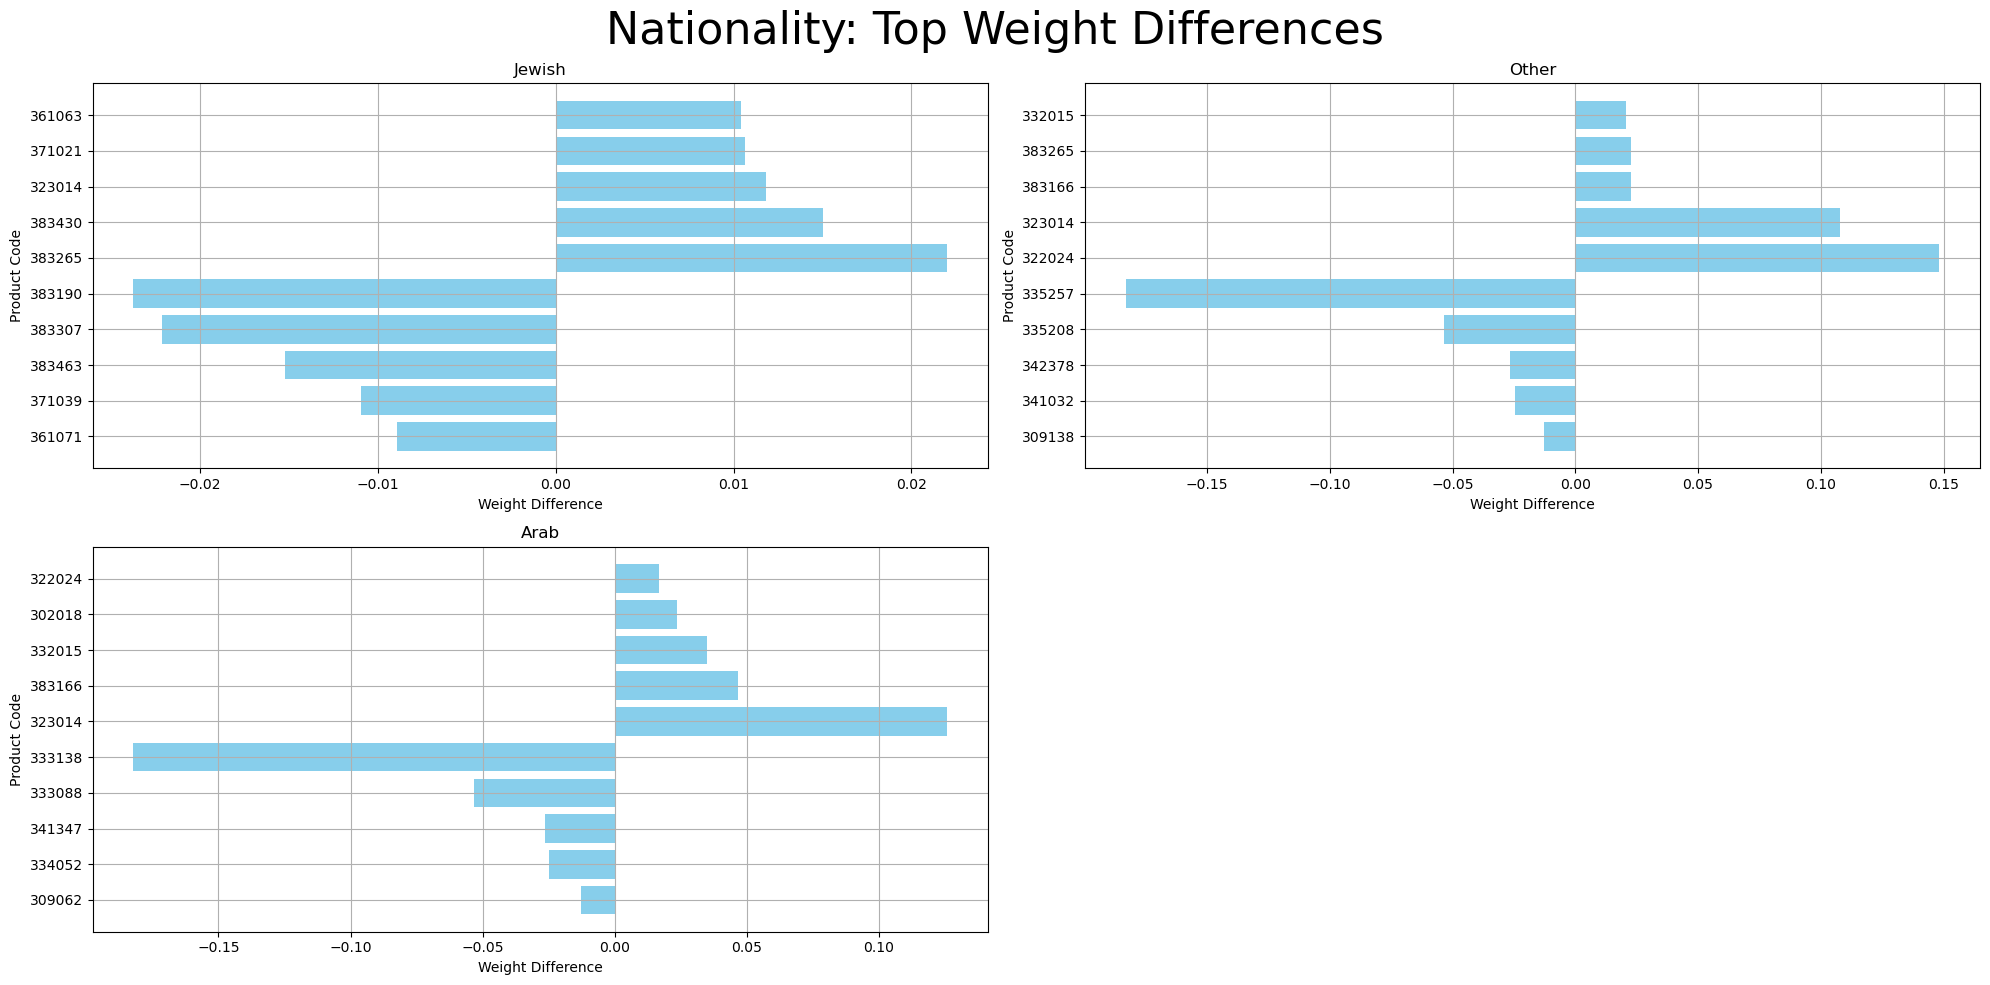

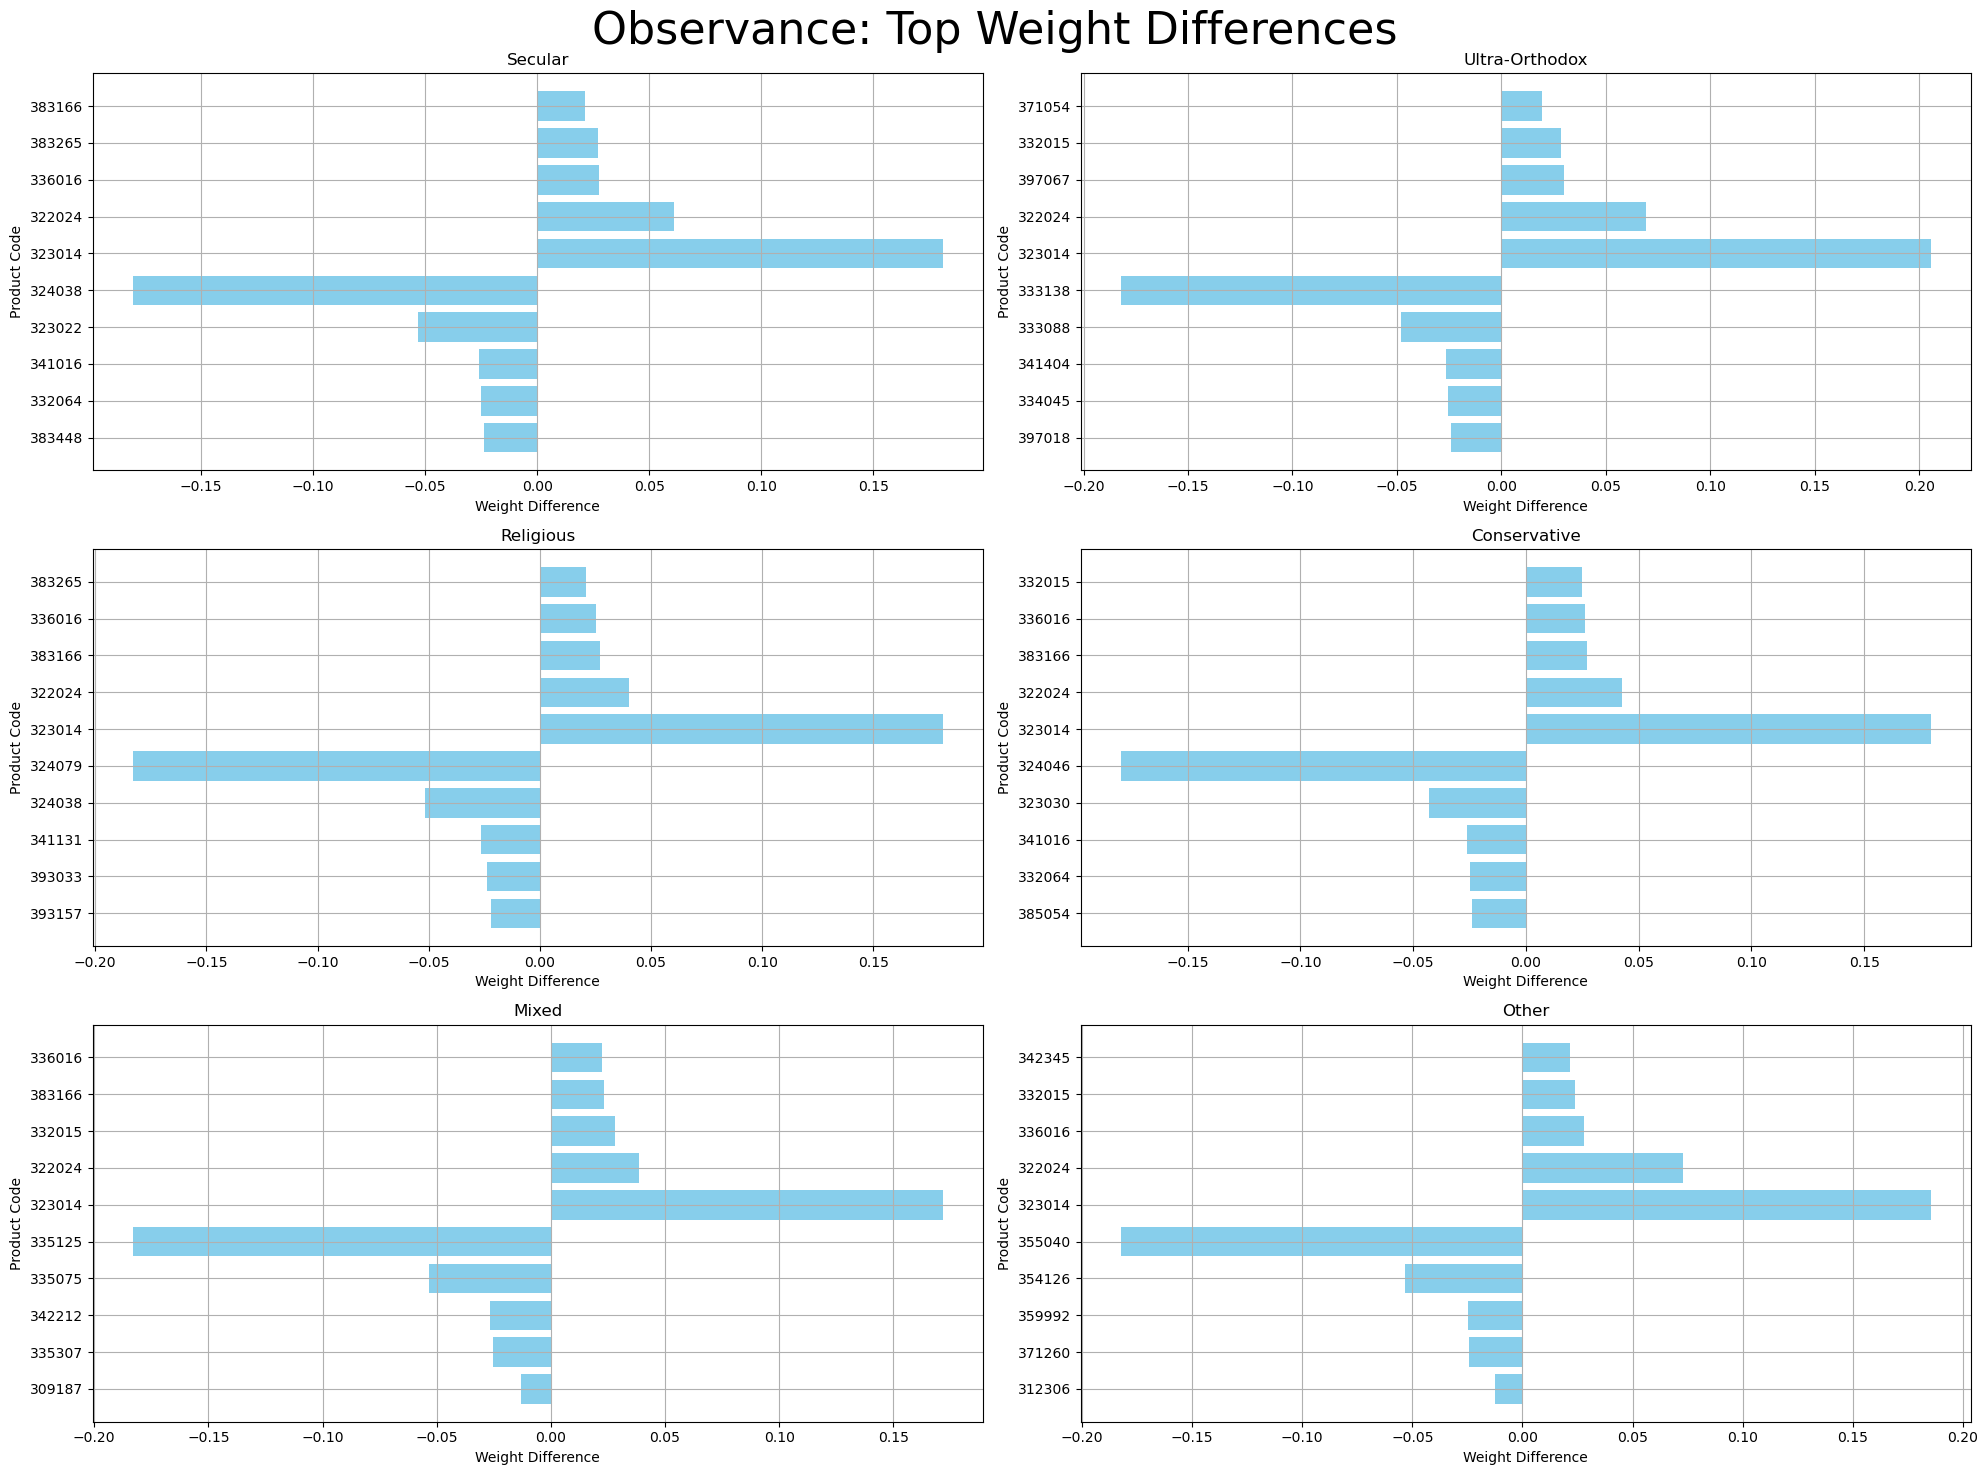

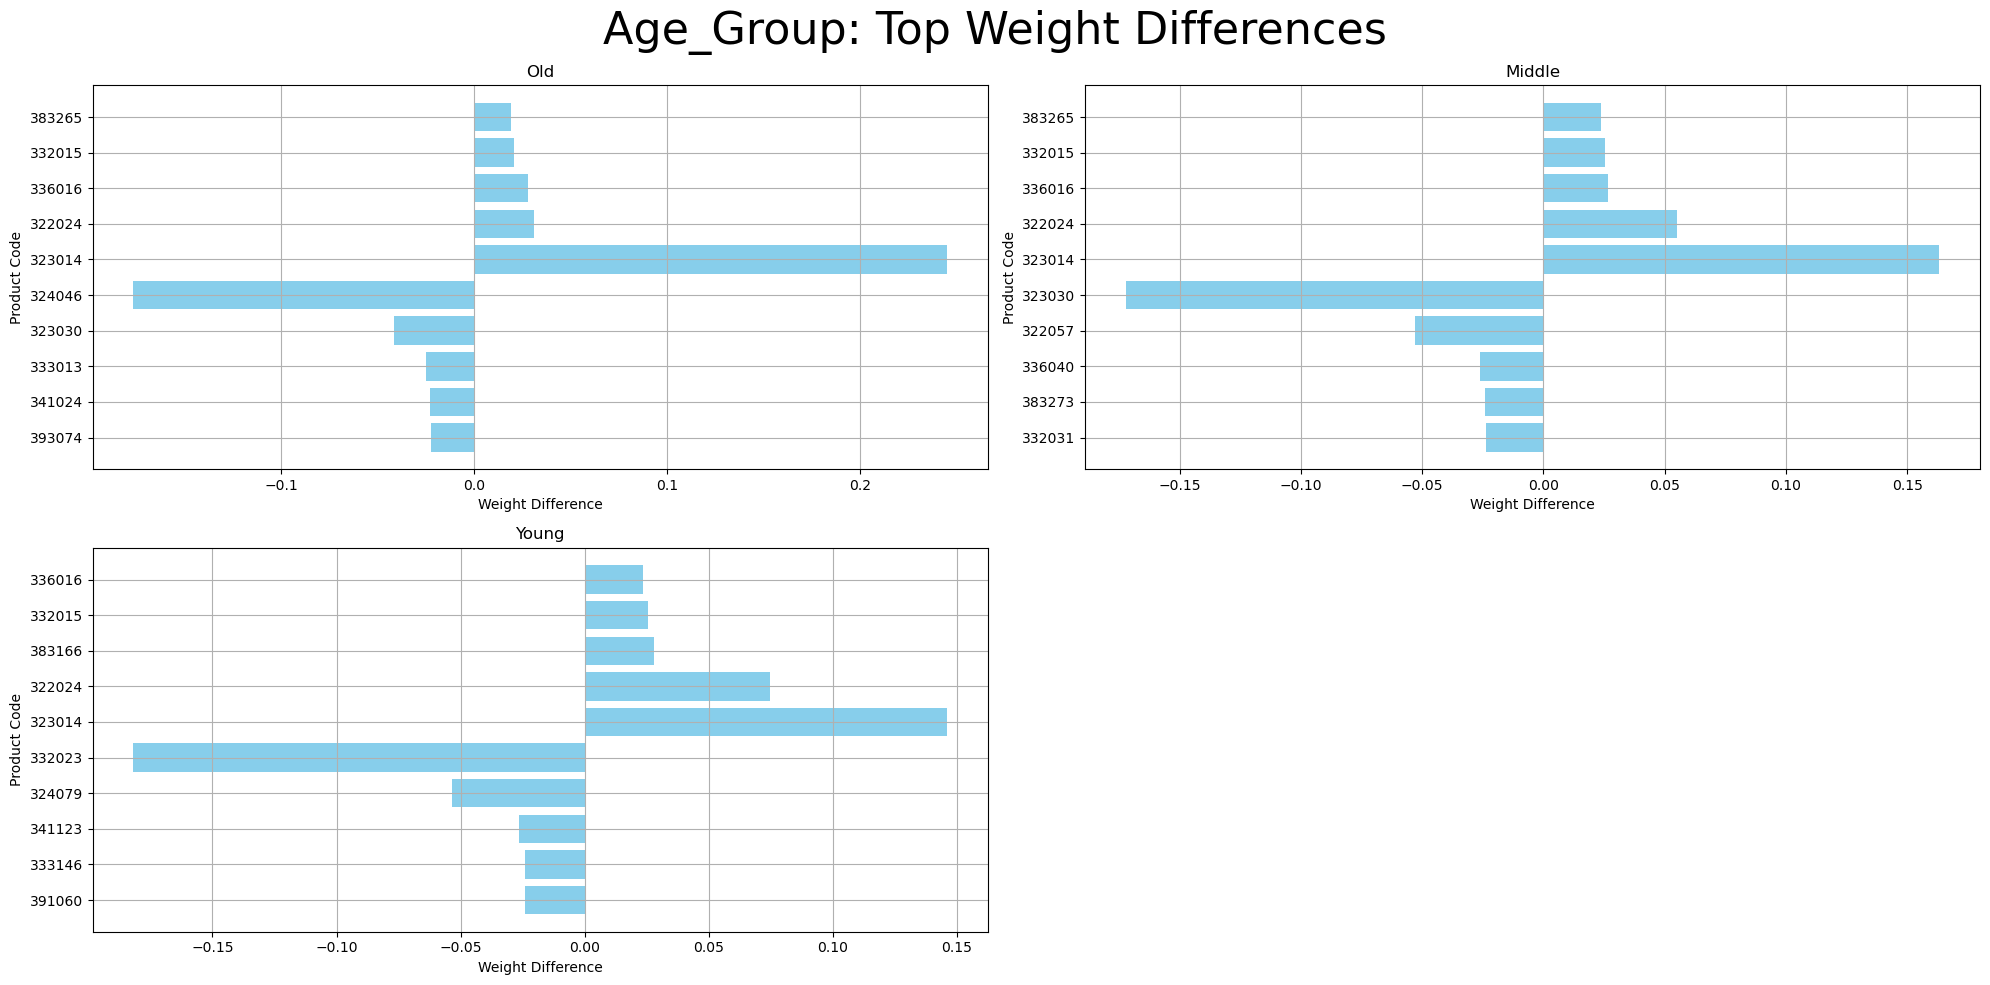

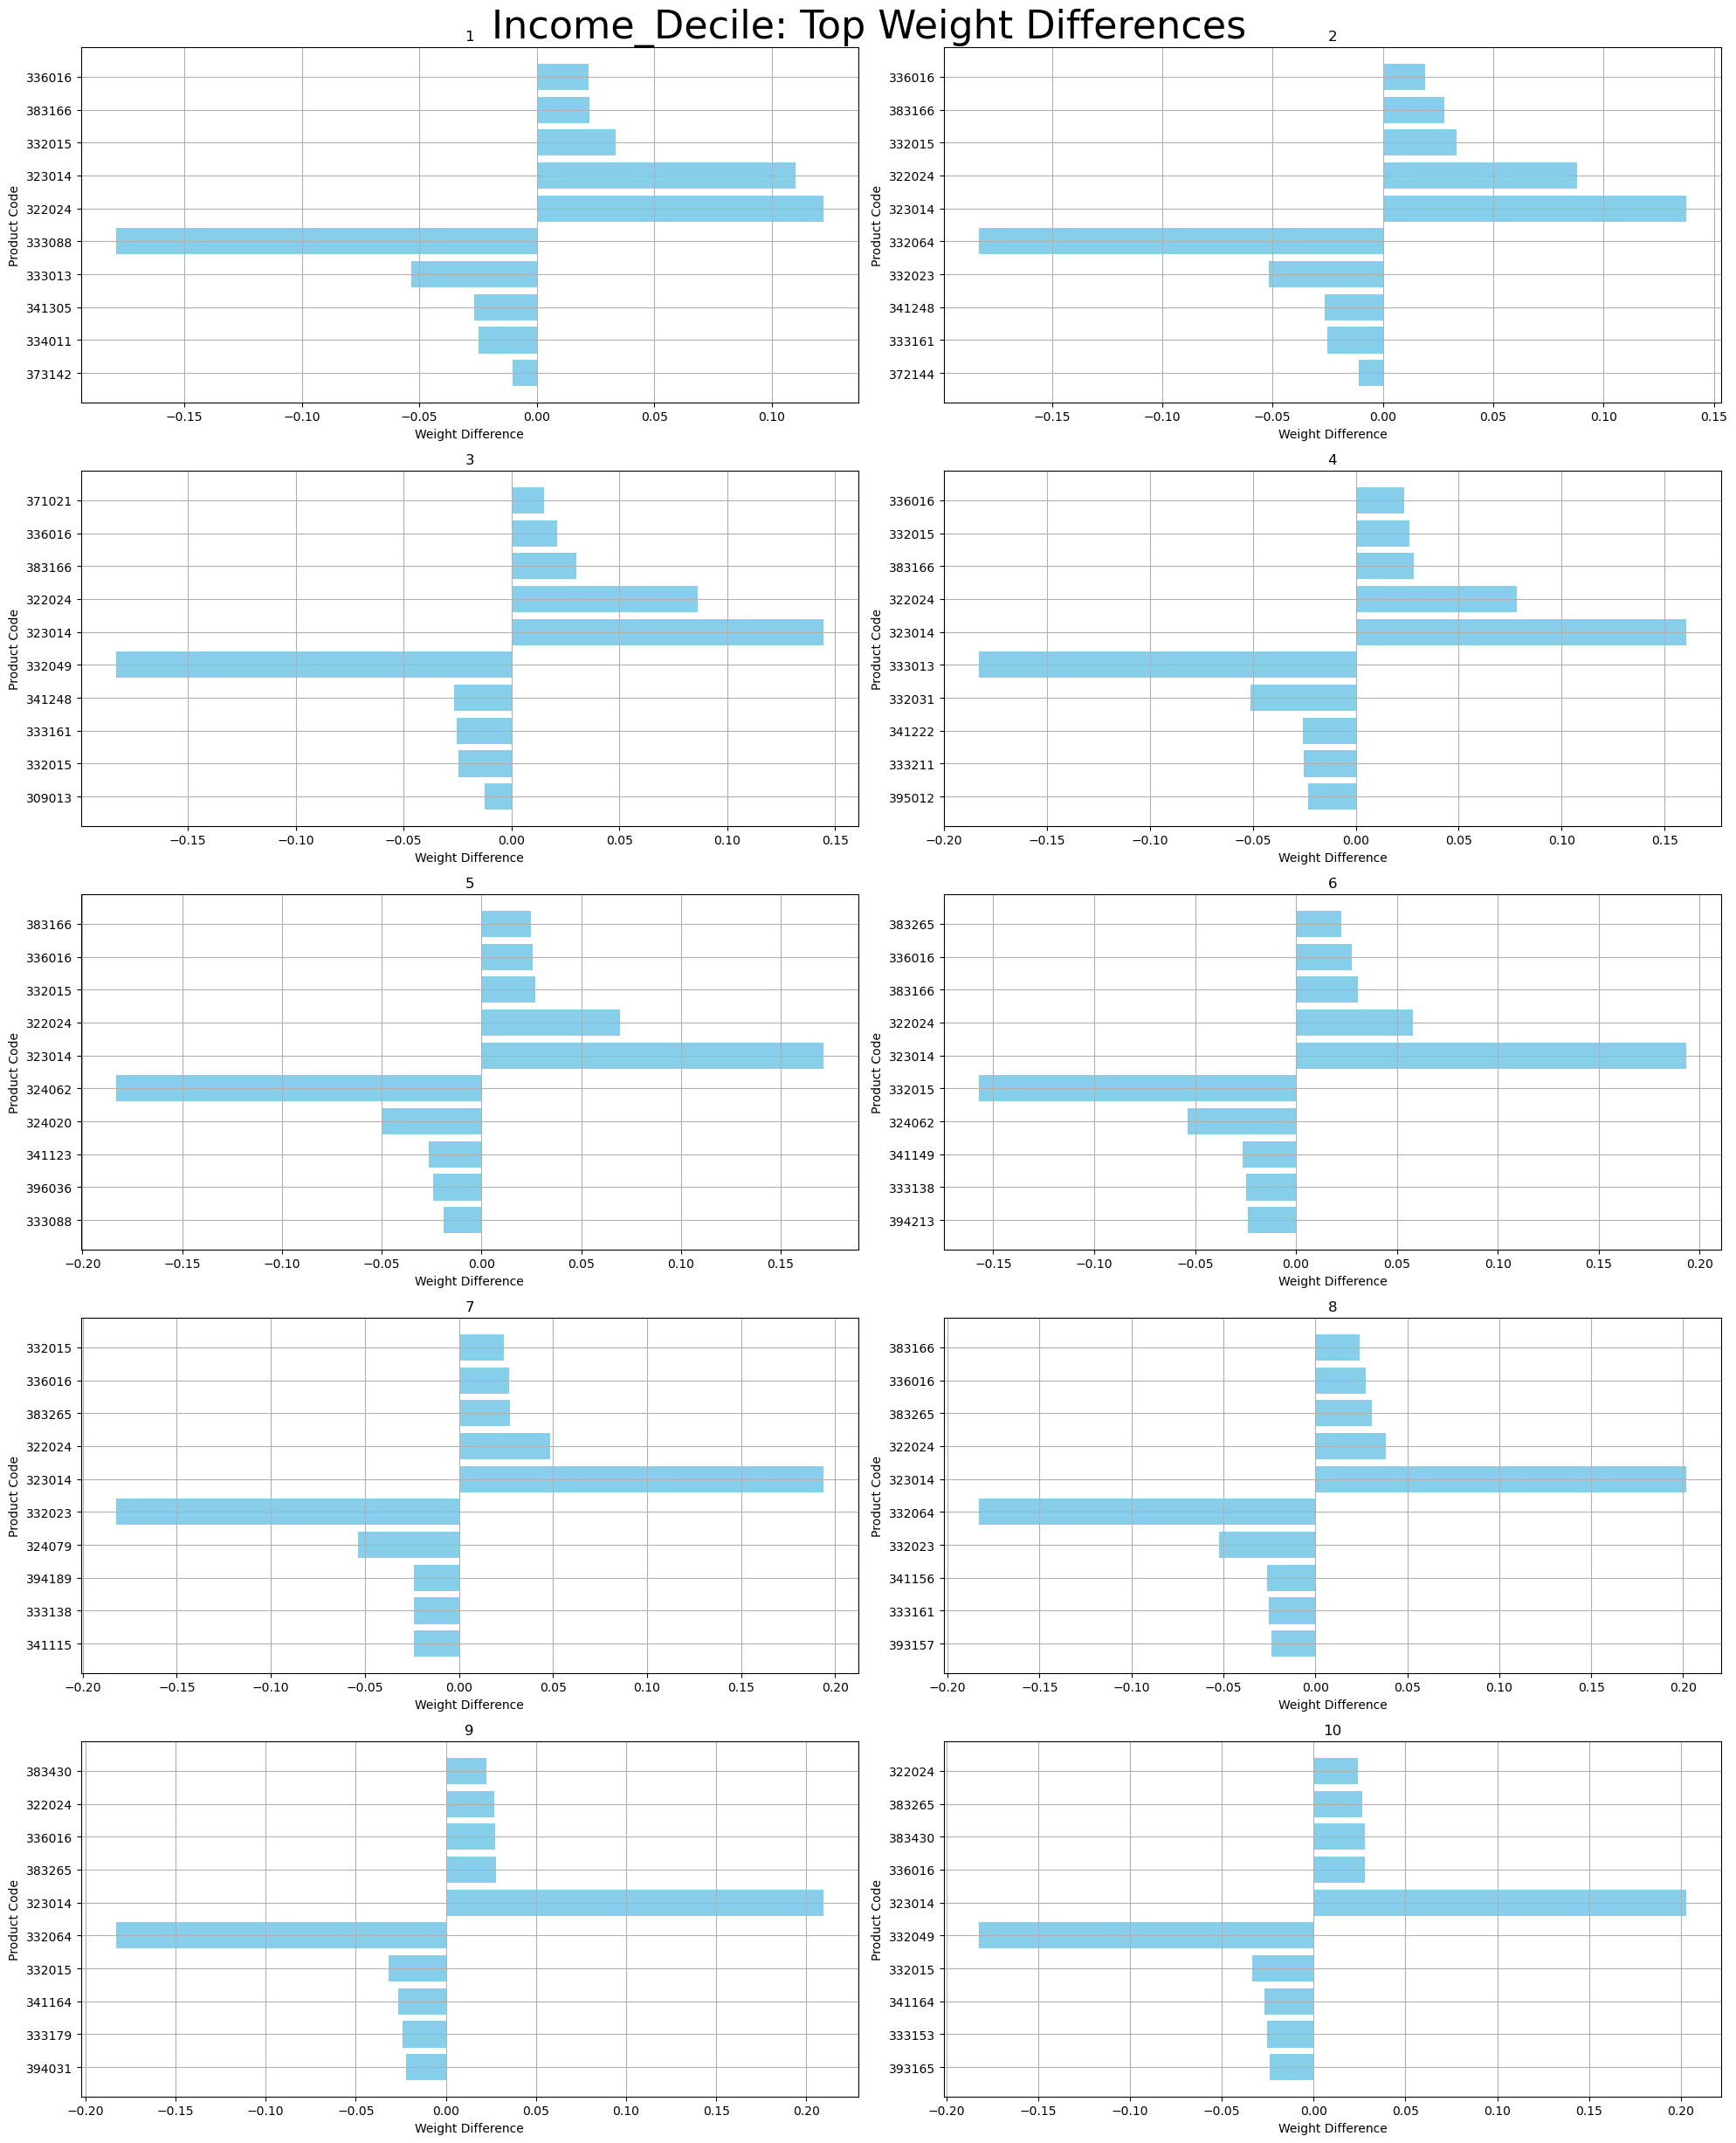

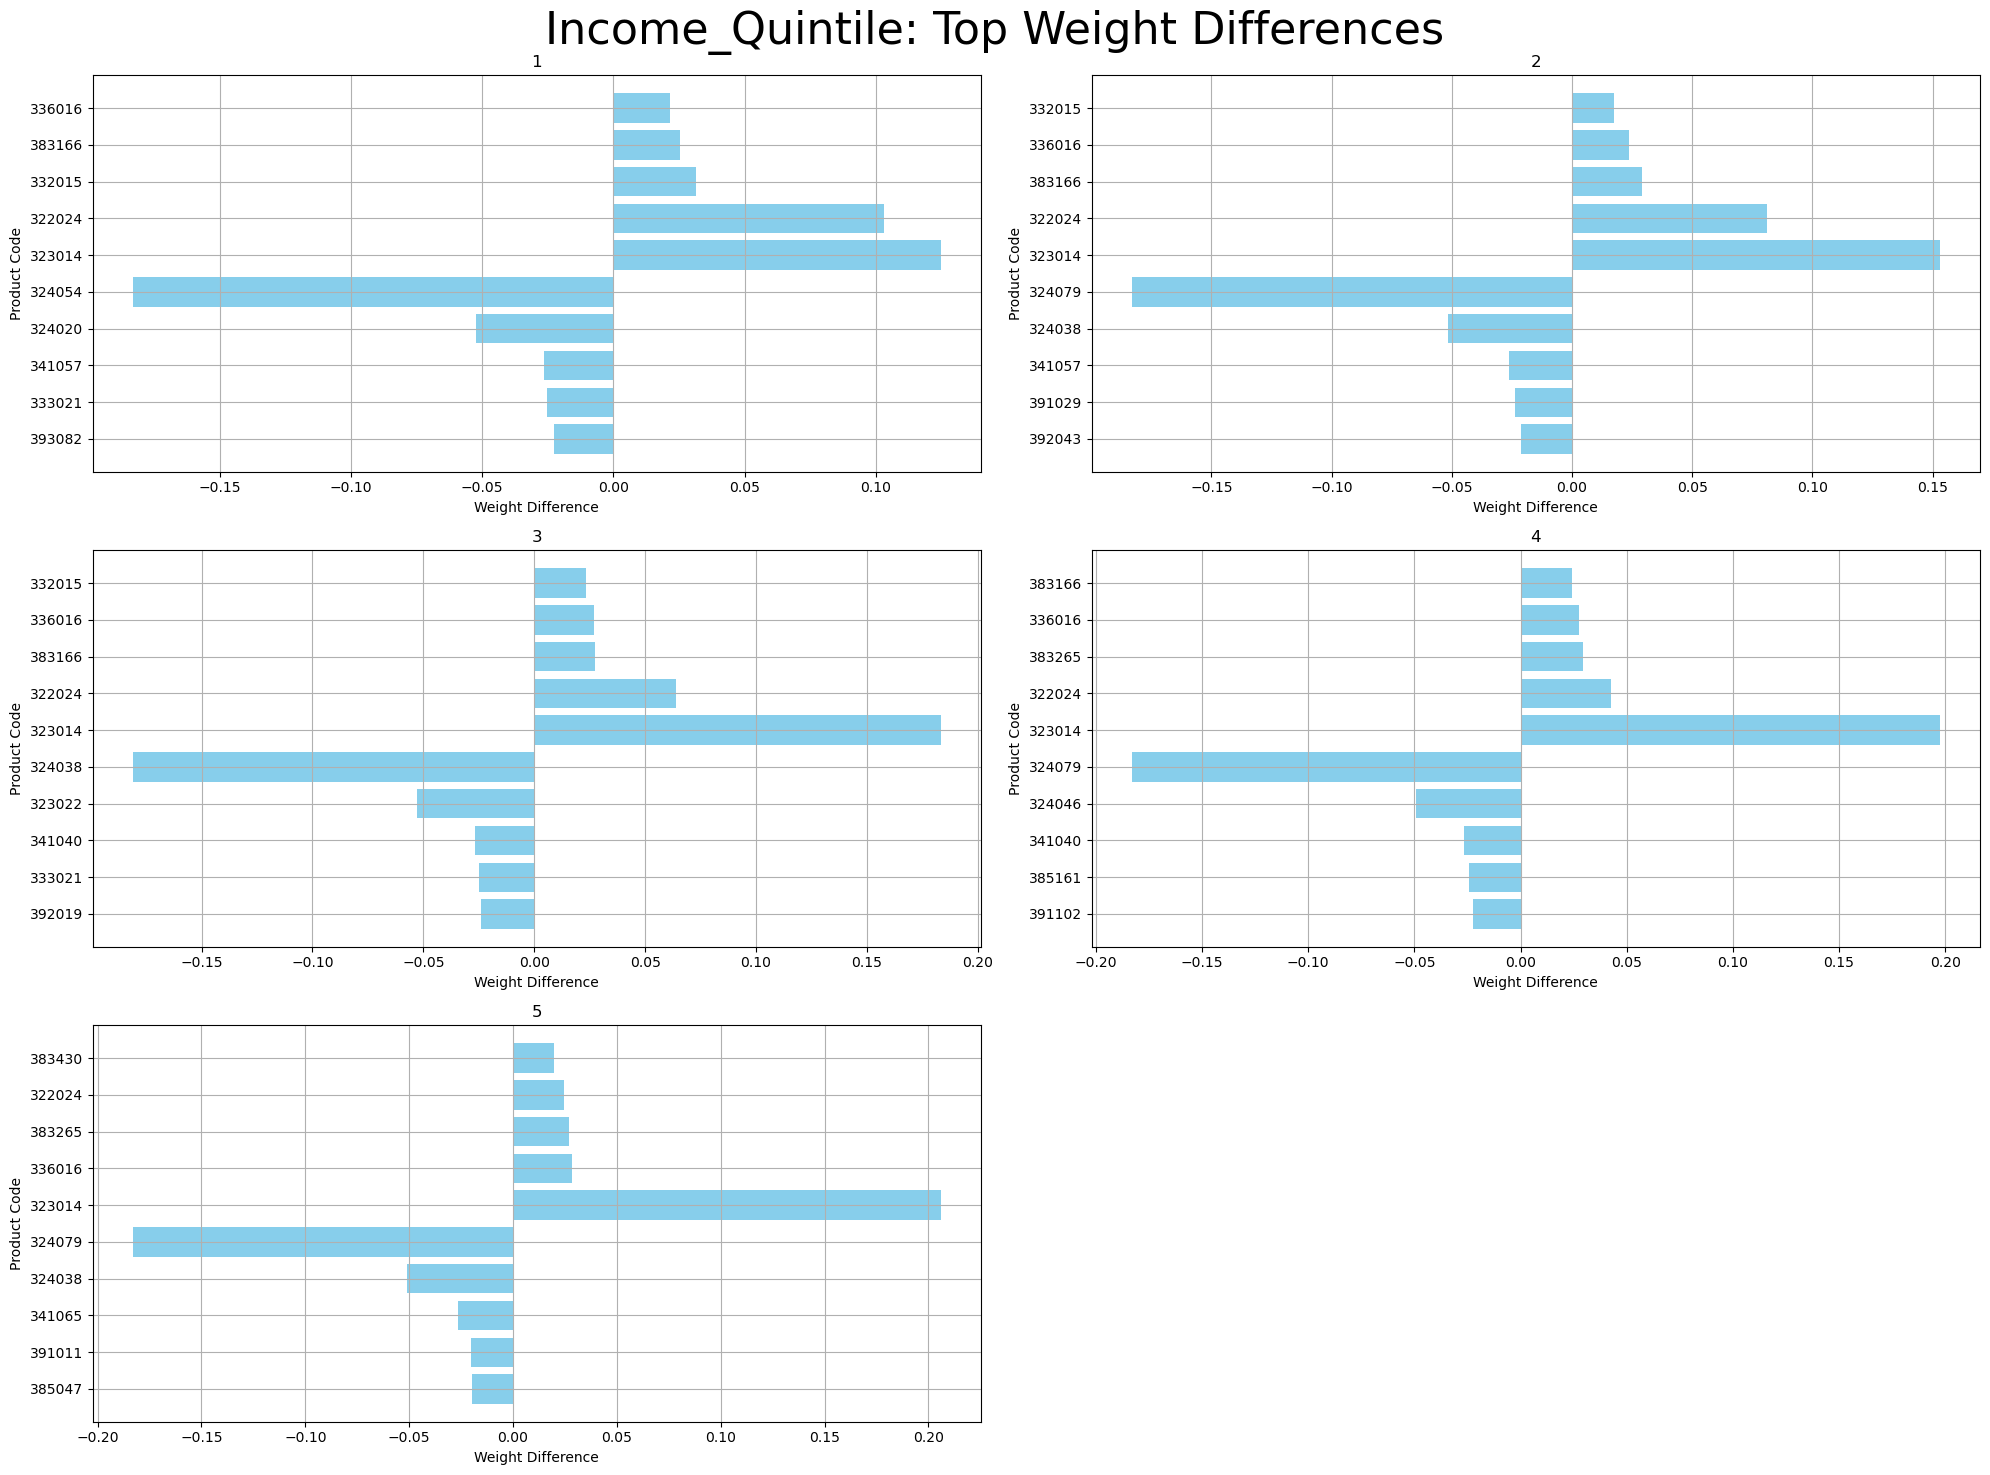

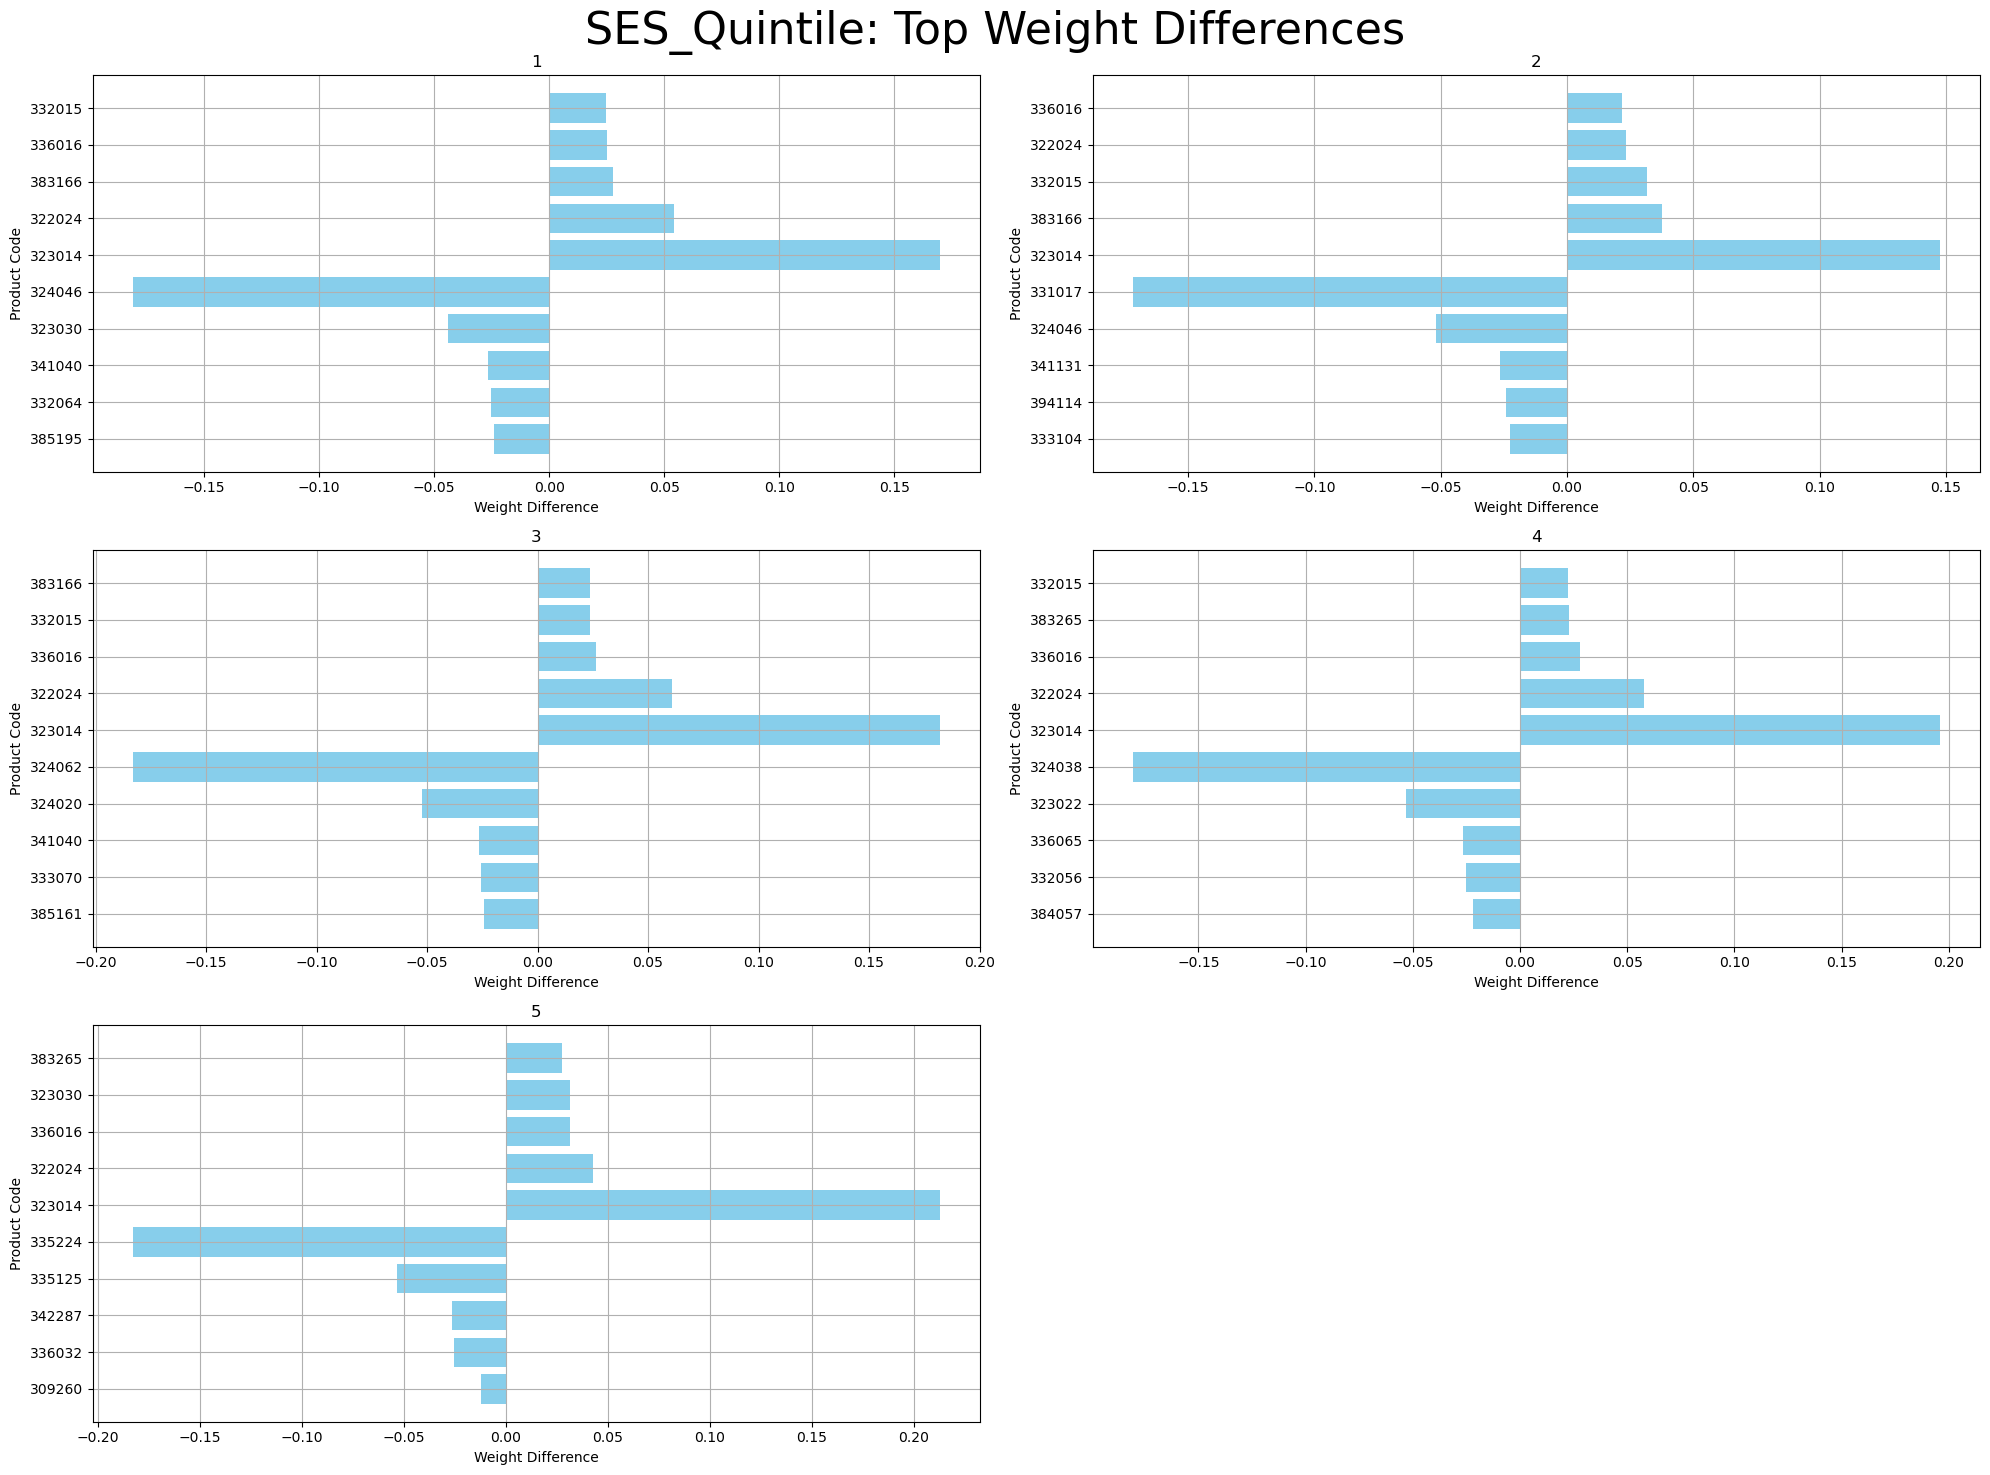

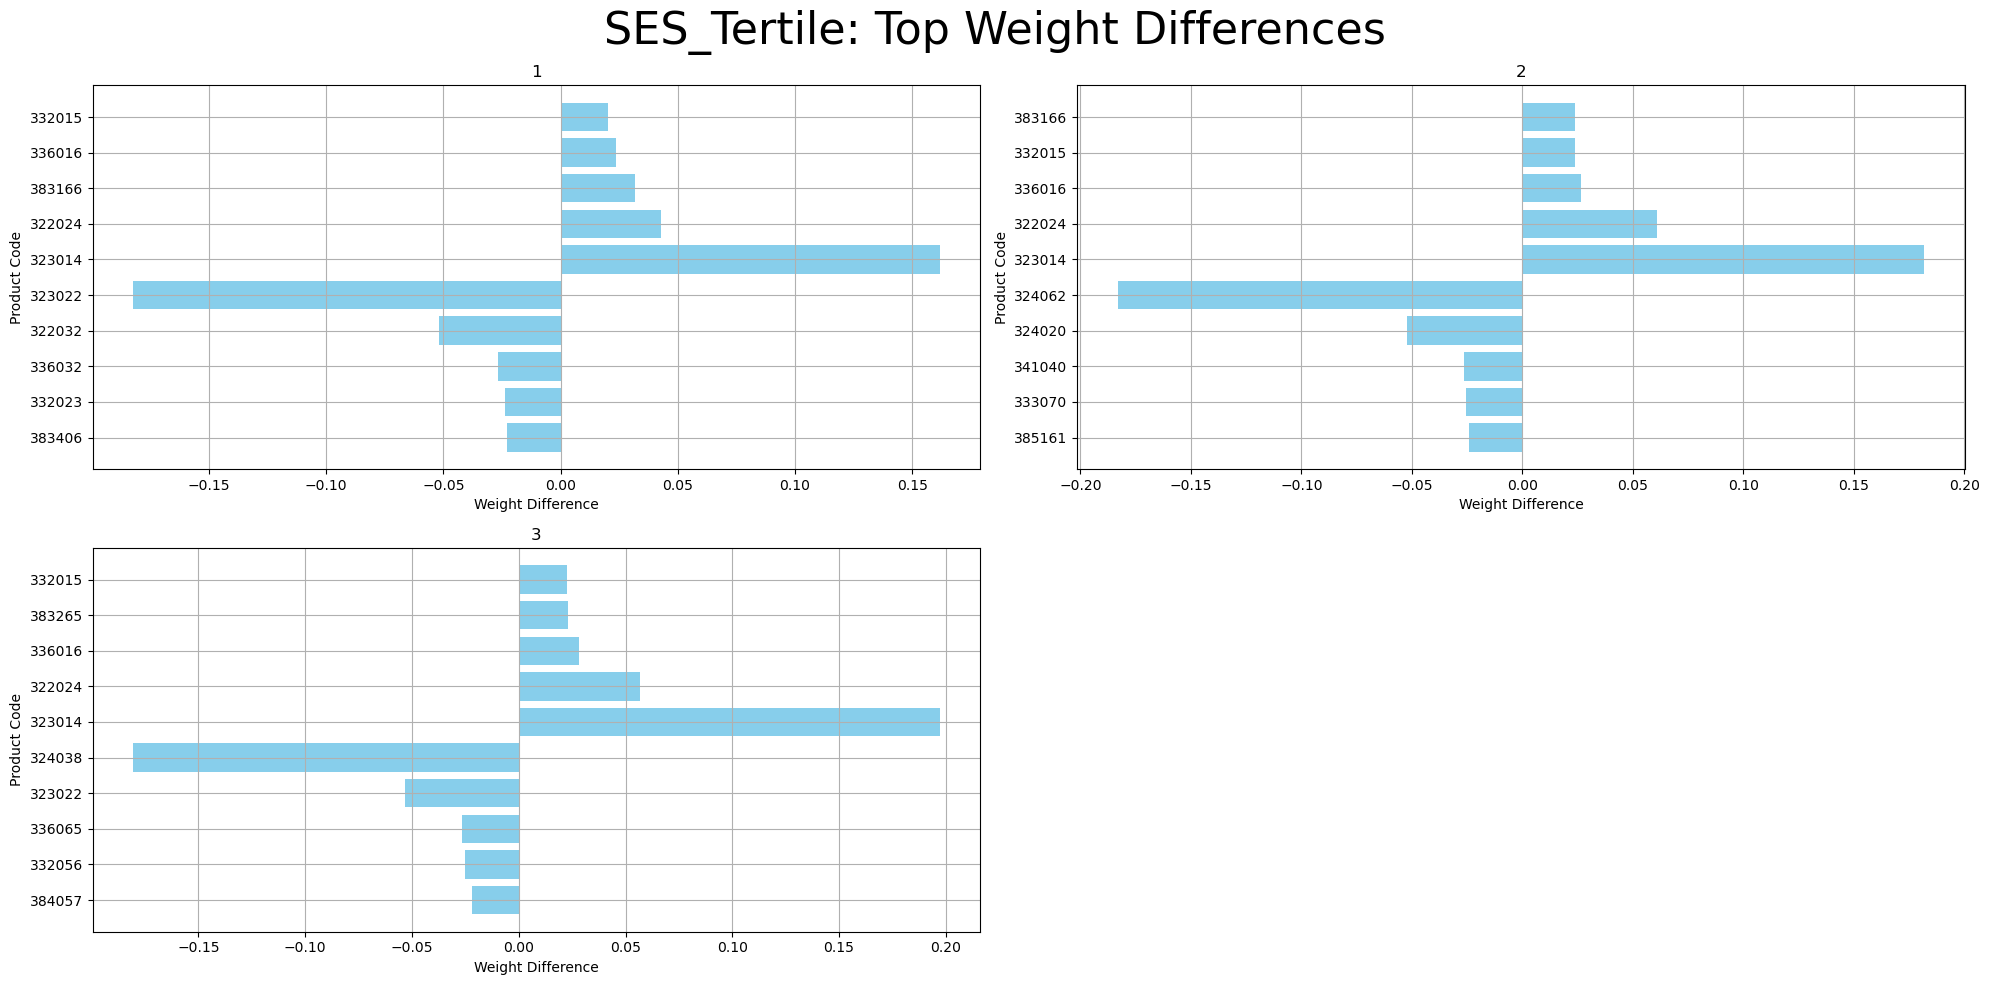

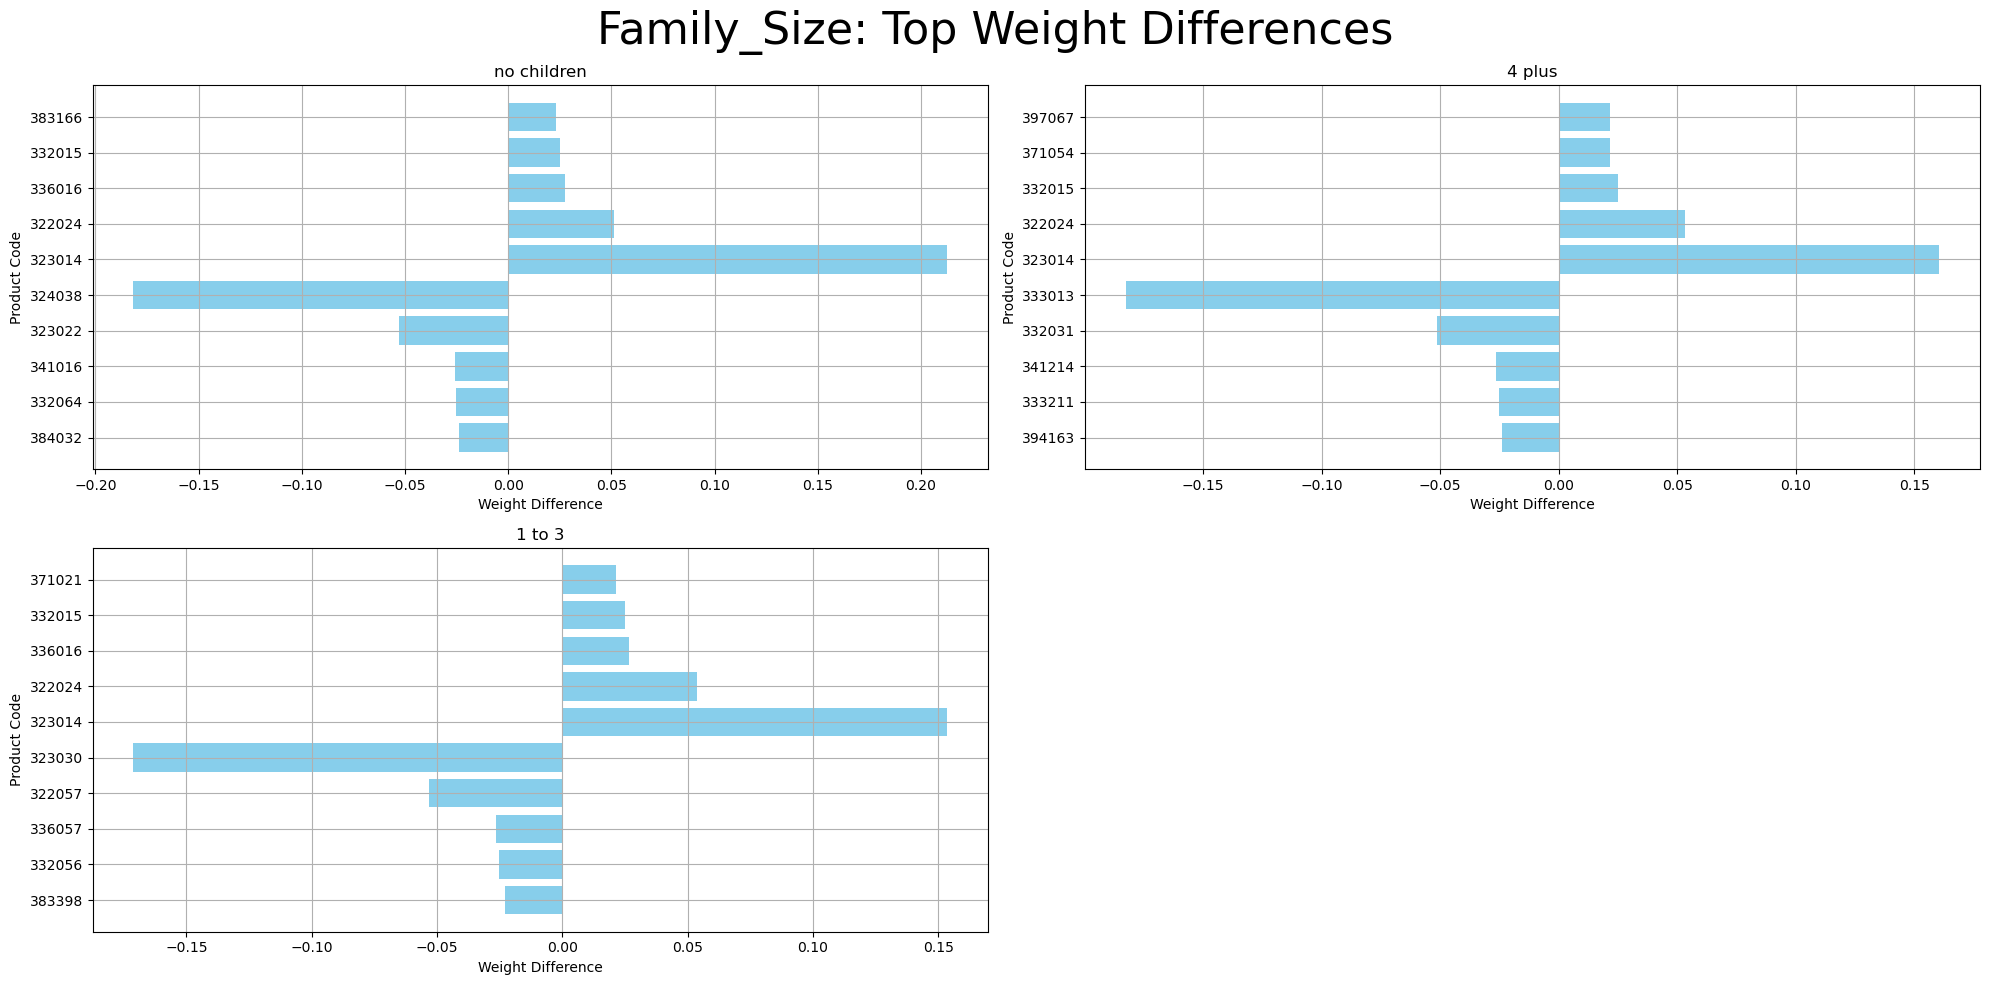

In [64]:
def top_abs_weight_differences(weights, top_n=10):
    import matplotlib.pyplot as plt
    import pandas as pd
    from IPython.display import display, HTML

    for group in weights.keys():
        if group == 'All':
            continue

        subgroups = weights[group].keys()
        try:
            subgroups = sorted(subgroups, key=int)
        except ValueError:
            subgroups = weights[group].keys()
        n_subgroups = len(subgroups)
        ncols = 2
        nrows = (n_subgroups + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows), sharey=False)
        axes = axes.flatten()

        axis_max = 0
        axis_min = 0
        weights_diff_df = {}
        for i, subgroup in enumerate(subgroups):
            # Calculate the weight differences between the subgroup and the control group
            weights_diff_df[subgroup] = weights[group][subgroup].copy()
            weights_diff_df[subgroup]['weight_diff'] = weights_diff_df[subgroup]['weight'] - weights['All']['weight']

            # Sort by the weight differences in descending order
            sorted_weights_diff_df = weights_diff_df[subgroup].sort_values(by='weight_diff', ascending=True)

            # Select the top n positive gaps
            top_n_positive = sorted_weights_diff_df.head(top_n)
            top_n_positive = top_n_positive.iloc[::-1]

            # Sort by the weight differences in ascending order
            sorted_weights_diff_df = weights_diff_df[subgroup].sort_values(by='weight_diff', ascending=False)

            # Select the top n negative gaps
            top_n_negative = sorted_weights_diff_df.head(top_n)

            # Concatenate the positive and negative gaps
            top_n_weights_diff_df = pd.concat([top_n_positive, top_n_negative])
            axis_max = max(axis_max, top_n_weights_diff_df['weight_diff'].max())
            axis_min = min(axis_min, top_n_weights_diff_df['weight_diff'].min())

            # Plot the top n largest gaps
            axes[i].barh(top_n_weights_diff_df['prodcode'], top_n_weights_diff_df['weight_diff'], color='skyblue')
            axes[i].set_title(subgroup)
            axes[i].set_xlabel('Weight Difference')
            axes[i].set_ylabel('Product Code')
            axes[i].grid(True)

        for ax in axes[len(subgroups):]:
            fig.delaxes(ax)

        fig.suptitle(f"{group}: Top Weight Differences", fontsize=32)
        plt.tight_layout()
        plt.show()

top_abs_weight_differences(weights, top_n)

In [ ]:
`# Export to html (optional: --no-input)
!jupyter nbconvert --to html Main.ipynb --no-input --output Main.html